In [38]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [39]:
import numpy as np
import pandas as pd
import datetime as dt
from scipy import stats

# Reflect Tables into SQLAlchemy ORM

In [40]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [41]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [42]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [43]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [44]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [45]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [46]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

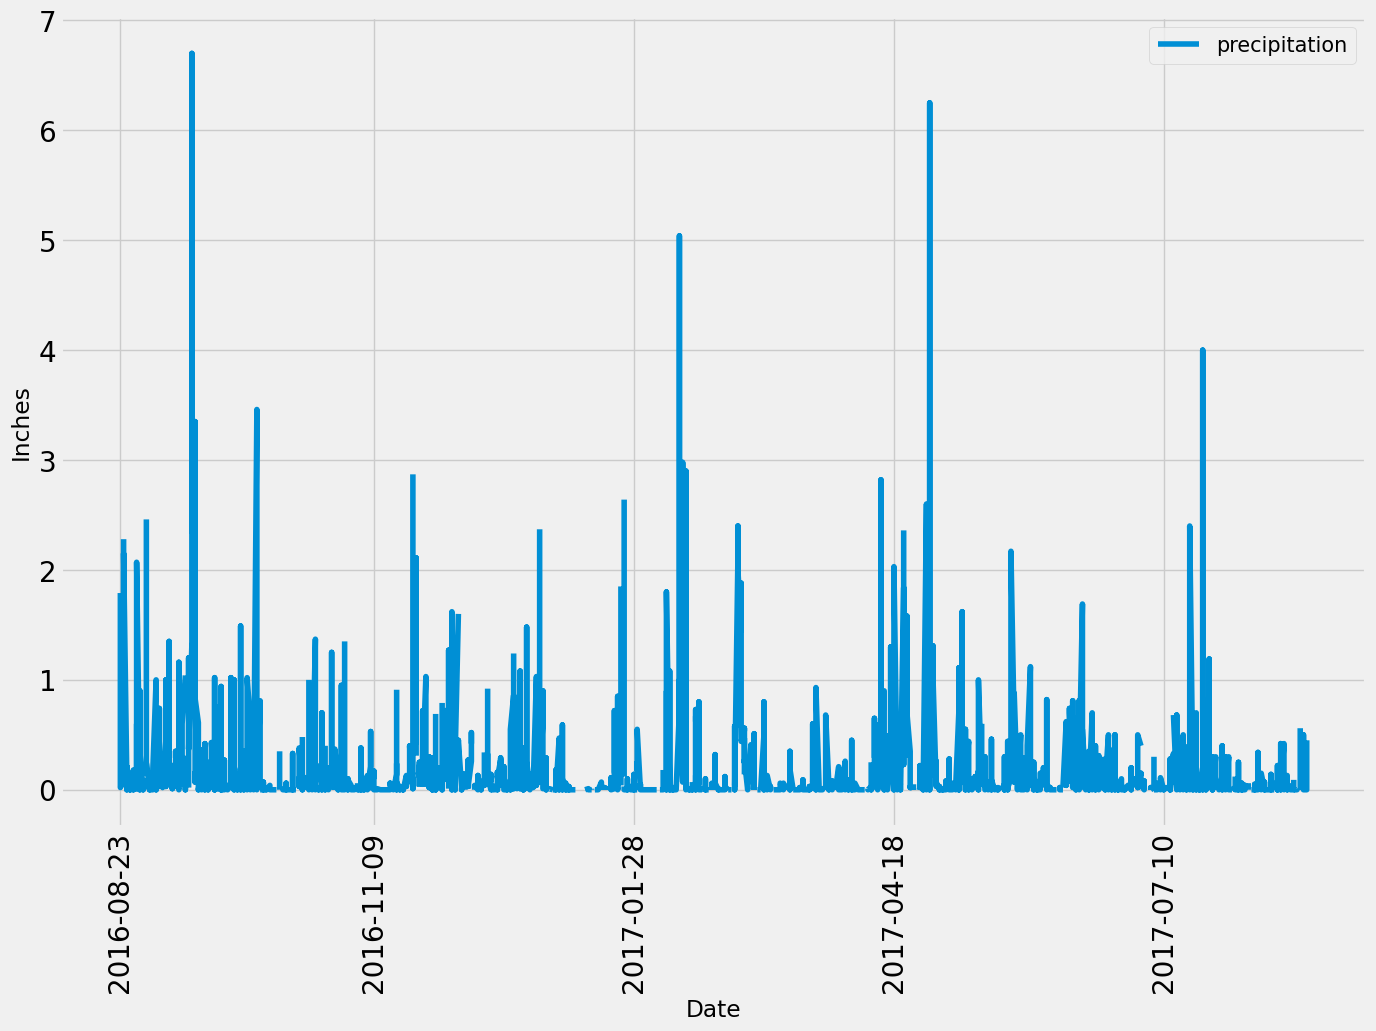

In [58]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date = session.query(func.max(Measurement.date)).scalar()

# Calculate the date one year from the last date in data set.
date_one_yr_ago_dt = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)
query_date = date_one_yr_ago_dt.strftime('%Y-%m-%d')

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= '2016-08-23').all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
last_year_df = pd.DataFrame(last_year)
last_year_df = last_year_df.set_index("date")

# Sort the dataframe by date
sorted_df = last_year_df.sort_values(by = "date")

# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,10))
plt.plot(sorted_df.index, sorted_df['prcp'])
plt.legend(['precipitation'], loc = "upper right", fontsize=15)
xloc = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']
plt.xticks(xloc, rotation='vertical',fontsize=20)
plt.yticks(size=20)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.savefig("Images/Precipitation_Plot.png", bbox_inches = 'tight')
plt.show()


In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [35]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
most_active_stations = [Station.station, func.count(Measurement.station)]
session.query(*most_active_stations).filter(Station.station == Measurement.station).\
        group_by(Station.station).\
        order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [36]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stations = [func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)]
most_active_station_data = session.query(*most_active_stations).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.id).desc()).first()
most_active_station_data

(54.0, 85.0, 71.66378066378067)

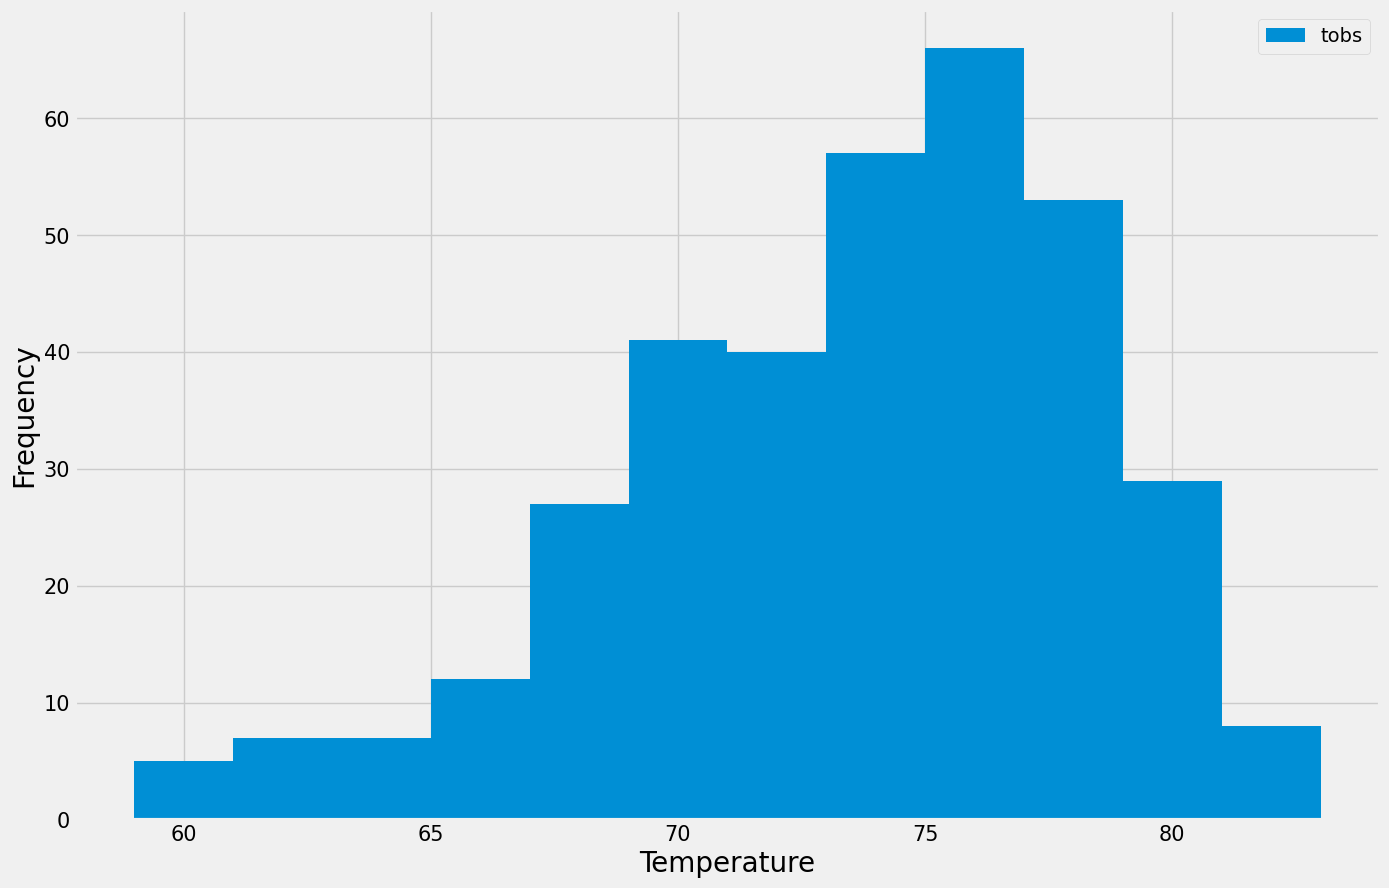

In [56]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
session.query(Measurement.station, func.count(Measurement.tobs)).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.tobs).desc()).first()


results = session.query(Measurement.tobs).\
            filter(Measurement.date.between(query_date,last_date),\
            Measurement.station == 'USC00519281').all()


plt.figure(figsize=(15,10))
plt.hist(np.ravel(results), bins=12)
plt.xlabel('Temperature',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.legend(['tobs'], loc = 'upper right')
plt.yticks(size=15)
plt.xticks(size=15)
plt.savefig("Images/station_Plot.png")
plt.show()


# Close Session

In [57]:
# Close Session
session.close()